In [7]:
from pymongo import MongoClient
import sys
sys.path.append('../statistical_calculations')  # Adds the statistical_calculations directory to the path
import disproportionaly_analysis
import pandas as pd
import json
from datetime import datetime, timedelta 
from calendar import monthrange

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
col = db['reports']

In [3]:
end_date = datetime(2020, 11, 30)

# Define a function to reduce the date range by a month
def reduce_date_range_by_month(start_date):
    # Get the year and month of the start date
    year = start_date.year
    month = start_date.month
    
    # Calculate the new year and month
    if month == 1:  # If the current month is January
        new_year = year - 1
        new_month = 12  # December of the previous year
    else:
        new_year = year
        new_month = month - 1
    
    # Construct the new start date
    _, last_day_of_previous_month = monthrange(new_year, new_month)
    new_start_date = datetime(new_year, new_month, last_day_of_previous_month)
    
    return new_start_date

In [5]:
# Loop until a signal is not found anymore

manufacturer = "PFIZER\\BIONTECH"
symptom = "Paraesthesia"
vaccine = "COVID19"
IC_intervals = []

 
start_date = datetime(2023, 12, 31)
first_found = datetime(2000, 1, 1)
while True:
    print(f'checking {start_date}')
    N_query = {"RECVDATE": {"$lte": start_date}}
    N = col.count_documents(N_query)
    
    D_query = {
        "RECVDATE": {"$lte": start_date},
        "vax_data": {
            "$elemMatch": {
                "VAX_MANU": manufacturer,
                "VAX_TYPE": vaccine
            }
        }
    }
    D = col.count_documents(D_query)
    
    E_query = {
        "RECVDATE": {"$lte": start_date},
        "symptoms": {
            "$elemMatch": {
                "$in": [symptom]
            }
        }
    }
    E = col.count_documents(E_query)
    
    DE_query = {'$and': [D_query, E_query]}
    DE = col.count_documents(DE_query)
    if DE >= 3: 
    
        De = D - DE
        dE = E - DE
        de = N - (DE + De + dE)
        
            
        # Ensure all necessary data is available
        if None in [DE, dE, De, de]:
            continue
        
        contingency_table = [
            [DE, dE],
            [De, de]
        ]

        IC = disproportionaly_analysis.information_component(contingency_table)
        IC_ci_lower, IC_ci_upper = disproportionaly_analysis.confidence_interval_information_component(contingency_table, IC)
        
        
        IC_intervals.append({
            'Date': start_date,
            'IC': IC,
            'IC Lower': IC_ci_lower,
            'IC Upper': IC_ci_upper
        })
        
        start_date = reduce_date_range_by_month(start_date)
        #print(f"Reducing by a month..., checking {start_date}")# Exit the loop if no signal is found anymore
        if start_date < end_date:
            break
    else:
        break

checking 2023-12-31 00:00:00
checking 2023-11-30 00:00:00
checking 2023-10-31 00:00:00
checking 2023-09-30 00:00:00
checking 2023-08-31 00:00:00
checking 2023-07-31 00:00:00
checking 2023-06-30 00:00:00
checking 2023-05-31 00:00:00
checking 2023-04-30 00:00:00
checking 2023-03-31 00:00:00
checking 2023-02-28 00:00:00
checking 2023-01-31 00:00:00
checking 2022-12-31 00:00:00
checking 2022-11-30 00:00:00
checking 2022-10-31 00:00:00
checking 2022-09-30 00:00:00
checking 2022-08-31 00:00:00
checking 2022-07-31 00:00:00
checking 2022-06-30 00:00:00
checking 2022-05-31 00:00:00
checking 2022-04-30 00:00:00
checking 2022-03-31 00:00:00
checking 2022-02-28 00:00:00
checking 2022-01-31 00:00:00
checking 2021-12-31 00:00:00
checking 2021-11-30 00:00:00
checking 2021-10-31 00:00:00
checking 2021-09-30 00:00:00
checking 2021-08-31 00:00:00
checking 2021-07-31 00:00:00
checking 2021-06-30 00:00:00
checking 2021-05-31 00:00:00
checking 2021-04-30 00:00:00
checking 2021-03-31 00:00:00
checking 2021-

In [8]:
df = pd.DataFrame(IC_intervals)

In [9]:
df

,Date,IC,IC Lower,IC Upper
0,2023-12-31,0.325941,0.325840,0.326042
1,2023-11-30,0.326296,0.326195,0.326397
2,2023-10-31,0.325843,0.325742,0.325944
3,2023-09-30,0.325845,0.325743,0.325946
4,2023-08-31,0.325098,0.324996,0.325199
5,2023-07-31,0.325284,0.325182,0.325386
6,2023-06-30,0.323332,0.323229,0.323434
7,2023-05-31,0.322796,0.322693,0.322899
8,2023-04-30,0.322266,0.322163,0.322369
9,2023-03-31,0.321022,0.320919,0.321125


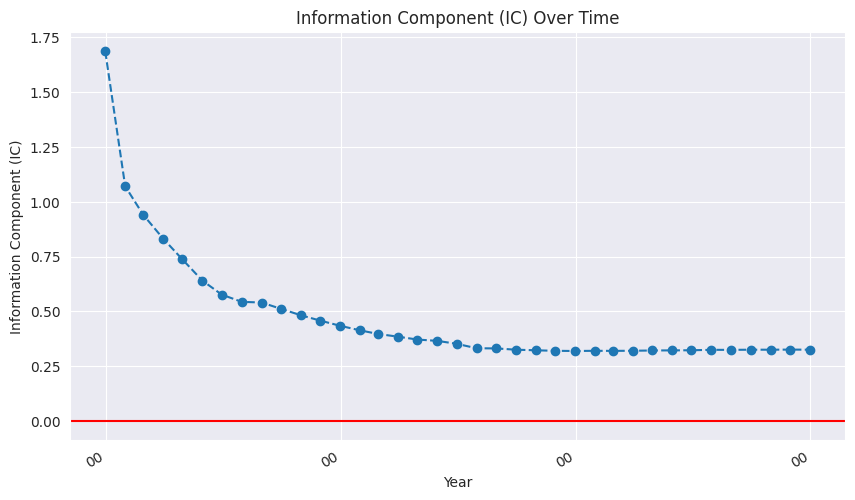

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.errorbar(df['Date'], df['IC'], yerr=[df['IC'] - df['IC Lower'], df['IC Upper'] - df['IC']], fmt='--o')

# Add a red horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='-')

# Format the x-axis to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M'))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Information Component (IC)')
plt.title('Information Component (IC) Over Time')

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()
